## Health Data (Life Expectancy Prediction)

We want to create a life expectancy prediction model to find put what are the top features to contribute to average
life expectancy in the United States counties.

## Data Exploration

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import statsmodels.api as sm



In [2]:
xcl = pd.ExcelFile('2019_County_Health_Rankings_Data_v2.xls')

In [3]:
ranked_measure = pd.read_excel(xcl, sheet_name='Ranked Measure Data')
ranked_measure.columns = list(ranked_measure.iloc[0])
ranked_measure.drop([0],inplace=True)

In [4]:
add_measure = pd.read_excel(xcl, sheet_name='Additional Measure Data')
add_measure.columns = list(add_measure.iloc[0])
add_measure.drop([0],inplace=True)

In [5]:
life_exp = add_measure[['FIPS','State','County','Life Expectancy', '% Frequent Physical Distress',
                       '% Frequent Mental Distress', '% Diabetic', '% Food Insecure',
                        '% Insufficient Sleep', 'Household Income', '% Homeowners',
                       '% Severe Housing Cost Burden']]
life_exp.head()

,FIPS,State,County,Life Expectancy,% Frequent Physical Distress,% Frequent Mental Distress,% Diabetic,% Food Insecure,% Insufficient Sleep,Household Income,% Homeowners,% Severe Housing Cost Burden
1,01001,Alabama,Autauga,76.3306,12.8244,12.6384,14.2,13.4,35.9054,58343,73.2877,12.6452
2,01003,Alabama,Baldwin,78.5995,12.622,12.8226,11.3,12.3,33.3059,56607,72.8593,12.7959
3,01005,Alabama,Barbour,75.7795,16.2162,14.6323,18,23.2,38.5632,32490,62.5068,13.5868
4,01007,Alabama,Bibb,73.9283,13.163,12.854,14.9,15.8,38.1489,45795,75.3615,8.73389
5,01009,Alabama,Blount,74.5978,13.7201,13.8279,14.3,11,35.945,48253,78.521,8.1945


In [6]:
factors = ranked_measure[['FIPS',
                         '% Fair/Poor',
                         '% LBW', '% Smokers', '% Obese', 'Food Environment Index',
                         '% Physically Inactive', '% With Access', '% Excessive Drinking',
                         '% Alcohol-Impaired','Chlamydia Rate', 'Teen Birth Rate', '% Uninsured',
                          'Dentist Rate', 'Preventable Hosp. Rate', '% Screened', '% Vaccinated',
                         'Graduation Rate', '% Some College', '% Unemployed', '% Children in Poverty',
                          'Income Ratio', '% Single-Parent Households', 'Association Rate', 'Average Daily PM2.5',
                         'Presence of violation', '% Severe Housing Problems','% Drive Alone',
                         '% Long Commute - Drives Alone']]

In [7]:
print('Factors shape:', factors.shape)
print('Life Expectancy shape:', life_exp.shape)

Factors shape: (3142, 29)
Life Expectancy shape: (3142, 12)


In [8]:
df_merged = life_exp.merge(factors, how='left',on='FIPS')

In [9]:
df_merged.dropna(subset=['Life Expectancy'], inplace=True)

In [10]:
df_final = df_merged.dropna()
df_final.shape

(2738, 40)

Our aim to create a model to predict Life Expectancy by counties in the United States. 
Target value = Life Expectancy.

It is a Regression Task that we will be using independent variables from our data as predictors. We will follow feature and model selection process to reach a final model which will predict Life Expectancy most accuratly.

In [11]:
#Getting data with numerical columns 
num_col = []
for i in df_final.columns:
    if (type(df_final[i][0]) != str):
        num_col.append(i)

In [12]:
num = df_final[num_col].astype('float64')
num.head(3)

,Life Expectancy,% Frequent Physical Distress,% Frequent Mental Distress,% Diabetic,% Food Insecure,% Insufficient Sleep,Household Income,% Homeowners,% Severe Housing Cost Burden,% Fair/Poor,...,% Some College,% Unemployed,% Children in Poverty,Income Ratio,% Single-Parent Households,Association Rate,Average Daily PM2.5,% Severe Housing Problems,% Drive Alone,% Long Commute - Drives Alone
0,76.330589,12.824434,12.638357,14.2,13.4,35.905406,58343.0,73.287736,12.645206,18.411124,...,60.854665,3.863522,19.3,4.636664,24.700097,12.631731,11.7,14.954646,85.965057,38.3
1,78.599498,12.622002,12.822558,11.3,12.3,33.305868,56607.0,72.859338,12.795922,18.060458,...,66.133926,3.988336,14.7,4.518560,25.184091,10.692213,10.3,13.831725,84.719423,40.5
2,75.779457,16.216160,14.632311,18.0,23.2,38.563167,32490.0,62.506800,13.586765,25.773416,...,36.774008,5.900923,50.3,5.755063,57.215743,8.472944,11.5,15.455531,83.404353,33.8


In [13]:
#Checking for duplicates
num.duplicated().sum()

0

## Preprocessing

At this point we will create a test set and put it aside to prevent any possible generalization error
and data snooping bias in our models

For this purpose we will use sklearn train_test_split function which allow us to plit our data into multiple
datasets

In [14]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(num, test_size=0.4, random_state=42)

In [15]:
print(len(train_set))

1642


In [16]:
train_set.describe()

,Life Expectancy,% Frequent Physical Distress,% Frequent Mental Distress,% Diabetic,% Food Insecure,% Insufficient Sleep,Household Income,% Homeowners,% Severe Housing Cost Burden,% Fair/Poor,...,% Some College,% Unemployed,% Children in Poverty,Income Ratio,% Single-Parent Households,Association Rate,Average Daily PM2.5,% Severe Housing Problems,% Drive Alone,% Long Commute - Drives Alone
count,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,...,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000
mean,77.285374,12.123664,12.335728,11.771133,13.791657,33.370873,51034.060292,71.471516,11.570391,17.671800,...,57.296458,4.702493,21.587637,4.527761,32.689169,13.276324,9.250914,14.192618,80.530514,31.176005
std,2.825107,2.287705,1.836382,2.602988,4.034780,4.071888,13578.881082,7.621626,3.420862,4.652676,...,11.494529,1.611186,9.082671,0.711629,9.794696,5.802586,1.812833,3.886849,5.813411,12.035394
min,66.497835,6.936987,8.128345,3.300000,3.700000,23.028348,24783.000000,26.946108,3.197807,8.289167,...,19.121601,1.759153,2.700000,2.670994,5.036556,0.000000,3.000000,5.075188,18.353071,3.200000
25%,75.391721,10.427354,10.979162,9.900000,11.100000,30.440985,42415.500000,67.604904,9.230583,14.227974,...,49.670846,3.600448,14.900000,4.024952,26.373573,9.515750,8.100000,11.586082,78.182564,21.800000
50%,77.387269,11.870226,12.246175,11.700000,13.200000,33.298960,48785.500000,72.571143,11.107397,17.018180,...,56.911549,4.449228,20.500000,4.433639,32.010942,12.525466,9.600000,13.787128,81.299093,30.700000
75%,79.149721,13.612300,13.547932,13.500000,15.800000,36.299968,56507.250000,76.684281,13.362096,20.709026,...,65.634100,5.514240,26.700000,4.879754,37.440550,15.827158,10.500000,16.205432,84.184084,39.475000
max,94.659083,20.899694,20.110109,20.900000,34.800000,46.707783,136191.000000,90.131780,28.063857,40.732355,...,88.539453,19.065964,62.300000,8.165117,79.776848,60.410793,17.800000,34.824557,92.570336,84.500000


In [17]:
for i in train_set.columns:
    train_set = train_set.loc[train_set[i] < np.percentile(train_set[i],99.5)]
    train_set = train_set.loc[train_set[i] > np.percentile(train_set[i],0.5)]

print(train_set.shape)    
train_set.describe()

(1084, 36)


,Life Expectancy,% Frequent Physical Distress,% Frequent Mental Distress,% Diabetic,% Food Insecure,% Insufficient Sleep,Household Income,% Homeowners,% Severe Housing Cost Burden,% Fair/Poor,...,% Some College,% Unemployed,% Children in Poverty,Income Ratio,% Single-Parent Households,Association Rate,Average Daily PM2.5,% Severe Housing Problems,% Drive Alone,% Long Commute - Drives Alone
count,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,...,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000
mean,77.037721,12.122206,12.391744,12.002306,13.684779,33.692511,50246.954797,71.906510,11.373160,17.472890,...,56.585967,4.672106,21.068819,4.459043,32.762459,13.269827,9.590775,13.899385,81.619229,31.772140
std,2.176142,1.800118,1.497183,2.099000,3.076233,3.480517,9473.929126,6.291948,2.750980,3.509335,...,9.465848,1.214322,6.644027,0.537926,7.055748,4.778336,1.585457,3.046072,3.943846,11.314729
min,70.150316,8.196592,8.894296,6.300000,6.400000,25.286969,30640.000000,48.449692,4.722793,10.640374,...,34.105263,2.320751,7.600000,3.368673,15.760266,3.815338,4.600000,7.410491,68.605991,8.100000
25%,75.527926,10.849745,11.313801,10.500000,11.500000,31.279237,43758.000000,68.212206,9.436828,14.807603,...,50.103810,3.786144,16.100000,4.056770,27.619143,9.910584,8.800000,11.828680,79.201152,23.000000
50%,77.054865,11.933290,12.327196,12.000000,13.400000,33.744351,48837.000000,72.571143,11.088884,17.150033,...,56.169707,4.523277,20.700000,4.414396,32.538106,12.742257,9.900000,13.744654,81.987112,31.350000
75%,78.608980,13.411288,13.450156,13.400000,15.500000,36.231563,55434.750000,76.348651,12.998159,19.961956,...,63.704499,5.389870,25.300000,4.766945,36.902094,15.608169,10.700000,15.778352,84.566933,39.700000
max,83.233000,17.711788,16.281440,18.300000,24.800000,42.292680,97627.000000,86.590629,21.323960,28.497625,...,78.468921,9.510026,41.200000,6.519856,56.340500,32.479939,12.800000,24.355876,89.736185,60.200000


In [18]:
#Removing outliers
train_set = train_set[(np.abs(stats.zscore(train_set)) < 3.2).all(axis=1)]
# train_set = train_set.loc[train_set['Life Expectancy'] < 82.0]
# train_set = train_set.loc[train_set['Injury Death Rate'] < 105.0]

In [19]:
print(len(train_set))

1000


In [20]:
train_set.reset_index(drop=True,inplace=True)

In [21]:
train_set.corrwith(train_set['Life Expectancy']).abs().sort_values(ascending=False).head(10)

Life Expectancy                 1.000000
% Fair/Poor                     0.665221
Teen Birth Rate                 0.660798
% Frequent Physical Distress    0.657161
% Frequent Mental Distress      0.653928
% Physically Inactive           0.644402
% Smokers                       0.617328
% Diabetic                      0.616026
% Children in Poverty           0.607863
Household Income                0.607067
dtype: float64

In [22]:
#Let's get top 7 attributes with the highest correlation to Life Expectancy to make our baseline model
# but first plot a heatmap to prevent any multicollinearity 
df_seven = train_set[['Life Expectancy', '% Smokers', '% Physically Inactive', 
               '% Frequent Physical Distress', 'Teen Birth Rate', '% Diabetic',
                     '% Frequent Mental Distress', '% Fair/Poor']]

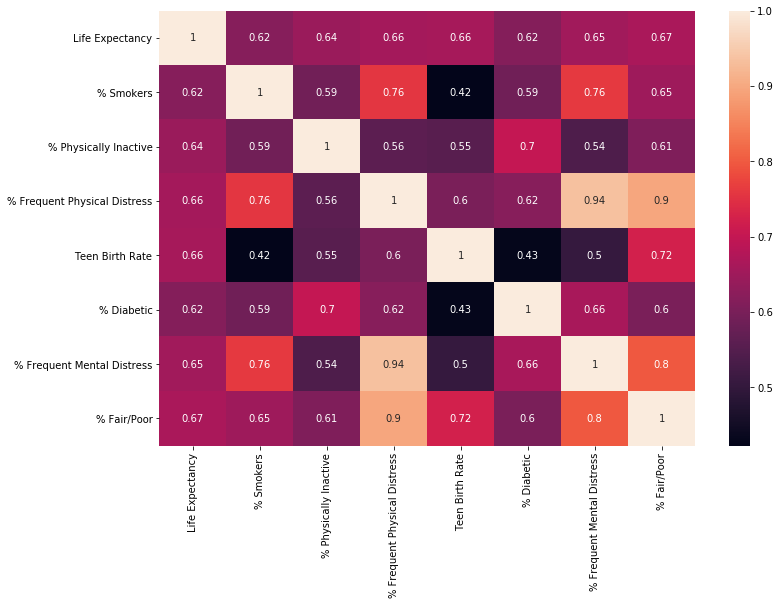

In [23]:
fig = plt.figure(figsize=(12,8))
sns.heatmap(df_seven.corr().abs(), annot=True)

There is a high chance of multicollinearity between two independent variables % Smokers, %Frequent Mental Distress and % Frequent Physical Distress and % Fair/Poor as we see from the heatmap above they are highly related to each other.

Life Expectancy is not normal 0.007174760636387142
% Smokers is not normal 6.41827906150393e-08
% Physically Inactive is not normal 0.047234654594848074
% Frequent Physical Distress is not normal 4.355152187394365e-06
Teen Birth Rate is not normal 1.6060495006507218e-06
% Diabetic is not normal 0.026950490126929506
% Frequent Mental Distress is not normal 0.000319633916276282
% Fair/Poor is not normal 1.0095420198039525e-06


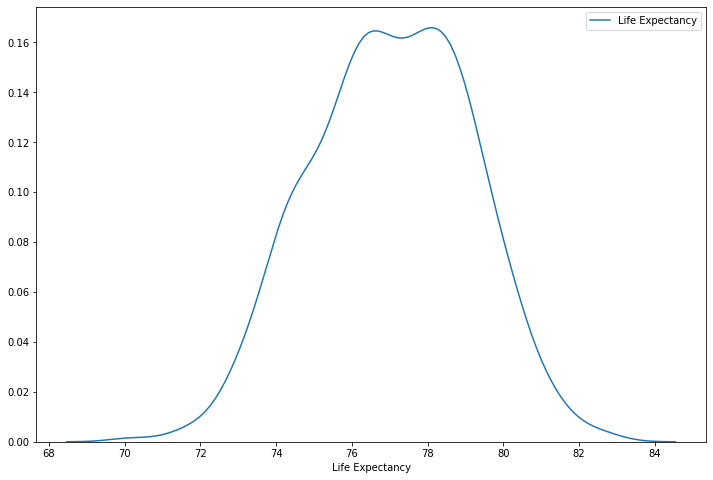

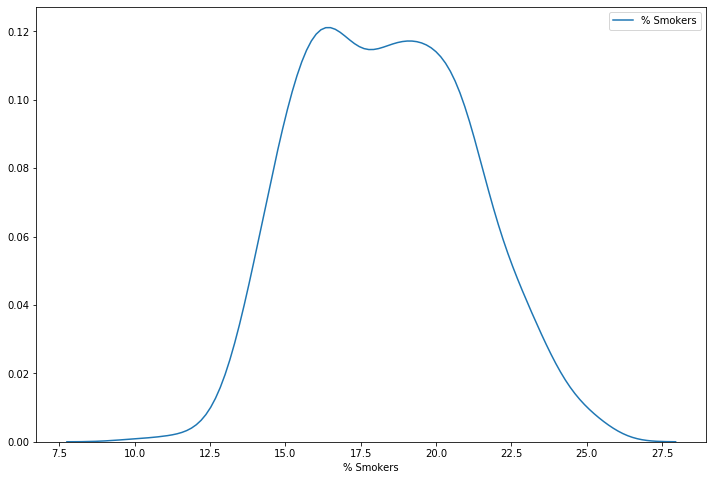

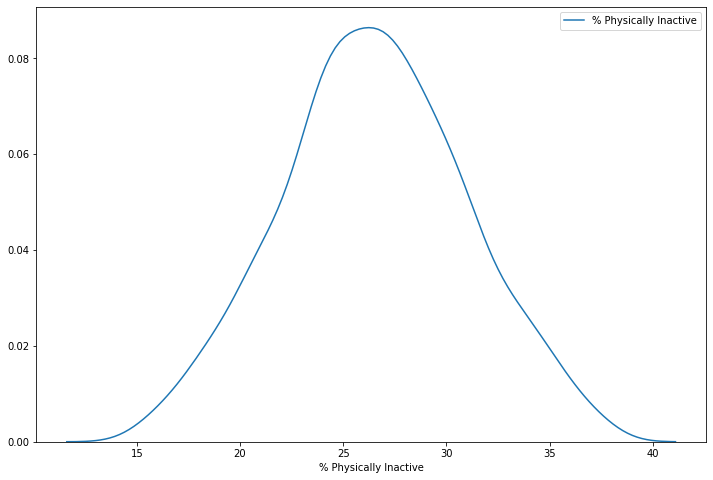

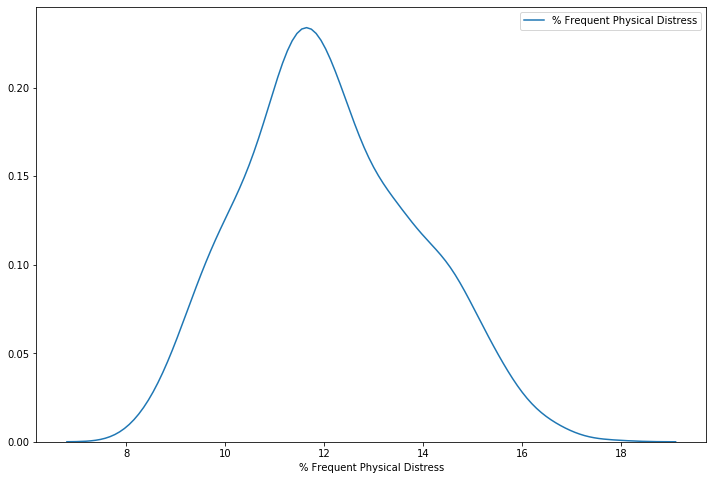

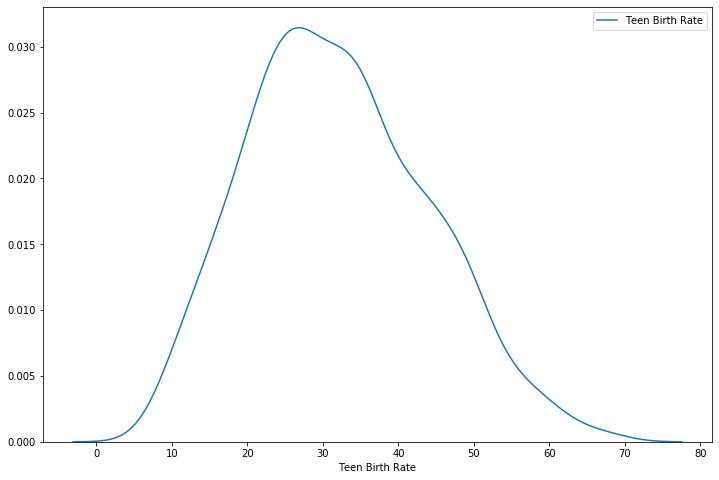

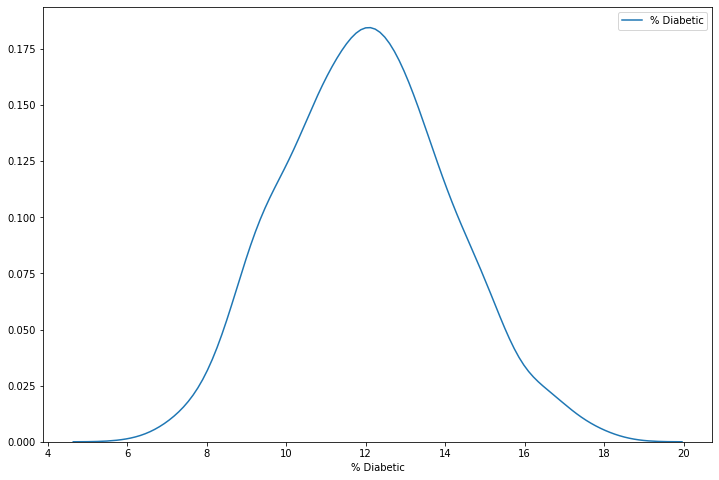

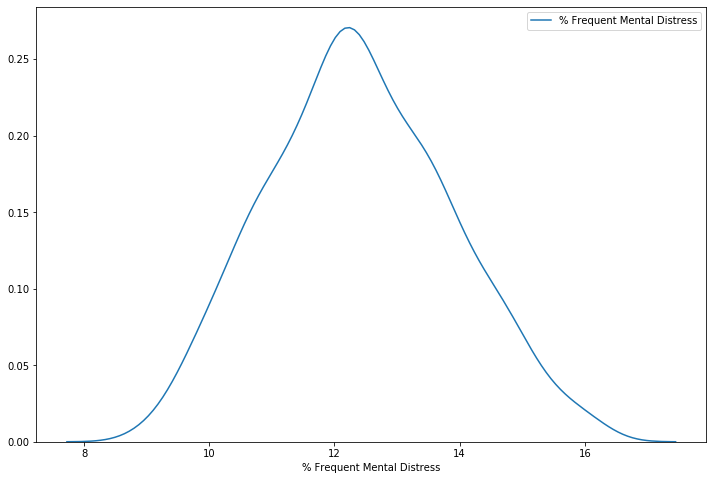

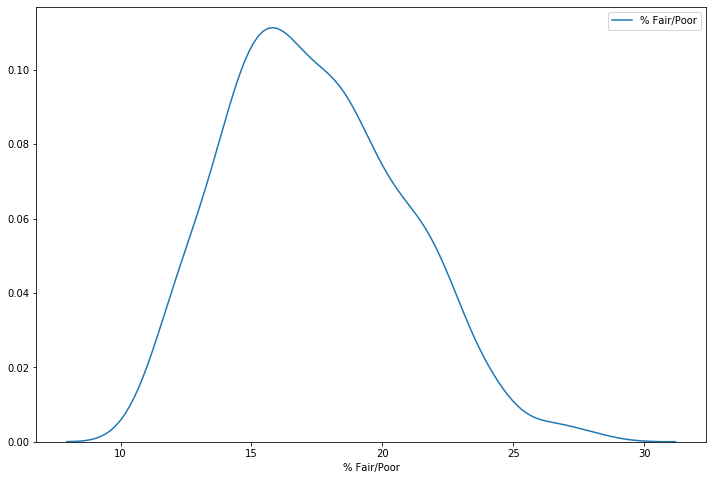

In [24]:
#Normality test
alpha = 0.05
for i in df_seven.columns:
    fig = plt.figure(figsize=(12,8))
    sns.distplot(df_seven[i], label=i, hist=False)
    k2, p = stats.normaltest(df_seven[i])
    if p < alpha:  # null hypothesis: x comes from a normal distribution
         print("%s is not normal"%i,p)
    else:
         print("%s is normal"%i)

Data doesn't look normal but for Linear Regression we don't need to normalize it since we will use Standard Scale.

In [25]:
target = train_set['Life Expectancy']
predictors1 = train_set[['% Smokers', 'Teen Birth Rate', '% Diabetic','% Physically Inactive', '% Fair/Poor' ]]

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled1 = scaler.fit_transform(predictors1)

In [27]:
df_scaled = pd.DataFrame(scaled1)
df_scaled.columns = predictors1.columns

We will run different regression models to see which one performs best for our task and choose a baseline model among them

## Model Selection

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [29]:
lin_reg = LinearRegression()
c_val = KFold(n_splits=5, shuffle=True, random_state=42)
# lin_reg.fit(scaled1, target)
scores = cross_val_score(lin_reg, scaled1, target, scoring='neg_mean_squared_error', cv=c_val)
lin_score_r2 = np.mean(cross_val_score(lin_reg, scaled1, target, scoring='r2', cv=c_val))
lin_scores_rmse = np.sqrt(-scores)

In [30]:
def display_scores(scores, r2):
    print('Scores: ', scores)
    print('Mean: ', scores.mean())
    print('Standard Deviation: ',scores.std())
    print('r2: ', r2)

In [31]:
display_scores(lin_scores_rmse,lin_score_r2)

Scores:  [1.30697936 1.32070846 1.26724356 1.19943581 1.33479649]
Mean:  1.2858327358432473
Standard Deviation:  0.04872562109534178
r2:  0.617679825515815


This is our baseline model. We will try to improve the model by adding more attributes. We will use only the attributes which has more than 0.4 correlation with Life Expectancy to keep our model as simple as possible. Before that we will check training data to make sure if there is any multicollinearity between independent variable.

In [32]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=.2) #Lasso is also known as the L1 norm. 
# lasso.fit(scaled1, target)
scores_lasso = cross_val_score(lasso, scaled1, target, scoring='neg_mean_squared_error', cv=c_val)
lasso_r2 = np.mean(cross_val_score(lasso, scaled1, target, scoring='r2', cv=c_val))
lasso_rmse = np.sqrt(-scores_lasso)
display_scores(lasso_rmse, lasso_r2)

Scores:  [1.32563084 1.38799346 1.27472606 1.22507991 1.34226872]
Mean:  1.3111397954883488
Standard Deviation:  0.056245444651589684
r2:  0.6039131145896336


In [33]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()


In [34]:
tree_reg.fit(scaled1, target)
scores_tree = cross_val_score(tree_reg, scaled1, target, scoring='neg_mean_squared_error', cv=10)
tree_score_r2 = np.mean(cross_val_score(tree_reg, scaled1, target, scoring='r2', cv=c_val))
tree_rmse_scores = np.sqrt(-scores_tree)
display_scores(tree_rmse_scores, tree_score_r2)

Scores:  [1.87956524 1.75867744 2.01982015 1.71559733 1.74223599 1.82174488
 1.5312484  1.47179394 1.71773853 1.75552421]
Mean:  1.7413946085523353
Standard Deviation:  0.14887517667712646
r2:  0.19386131485148345


In [35]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()


In [36]:
forest_reg.fit(scaled1, target)
scores_forest = cross_val_score(forest_reg, scaled1, target, scoring='neg_mean_squared_error', cv=10)
forest_score_r2 = np.mean(cross_val_score(forest_reg, scaled1, target, scoring='r2', cv=c_val))
forest_rmse_scores = np.sqrt(-scores_forest)
display_scores(forest_rmse_scores, forest_score_r2)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Scores:  [1.47477357 1.36019816 1.52366998 1.38018911 1.3135735  1.28193548
 1.31945293 1.18365378 1.32496759 1.35991231]
Mean:  1.3522326406812588
Standard Deviation:  0.09054500303690369
r2:  0.5474634908796446


Our baseline model will be the Linear Regression model.  We will try to improve the model by adding more attributes. We will use only the attributes which has more than 0.4 correlation with Life Expectancy to keep our model as simple as possible. Before that we will check training data to make sure if there is any multicollinearity between independent variable.

## Preprocessing before improving the model

In [37]:
attributes = pd.DataFrame(train_set.corrwith(train_set['Life Expectancy']).abs() > 0.3)
attributes.reset_index(inplace=True)
attributes.columns = ['Attribute','Correlation']
list_attr = attributes.loc[attributes['Correlation'] == True, 'Attribute']

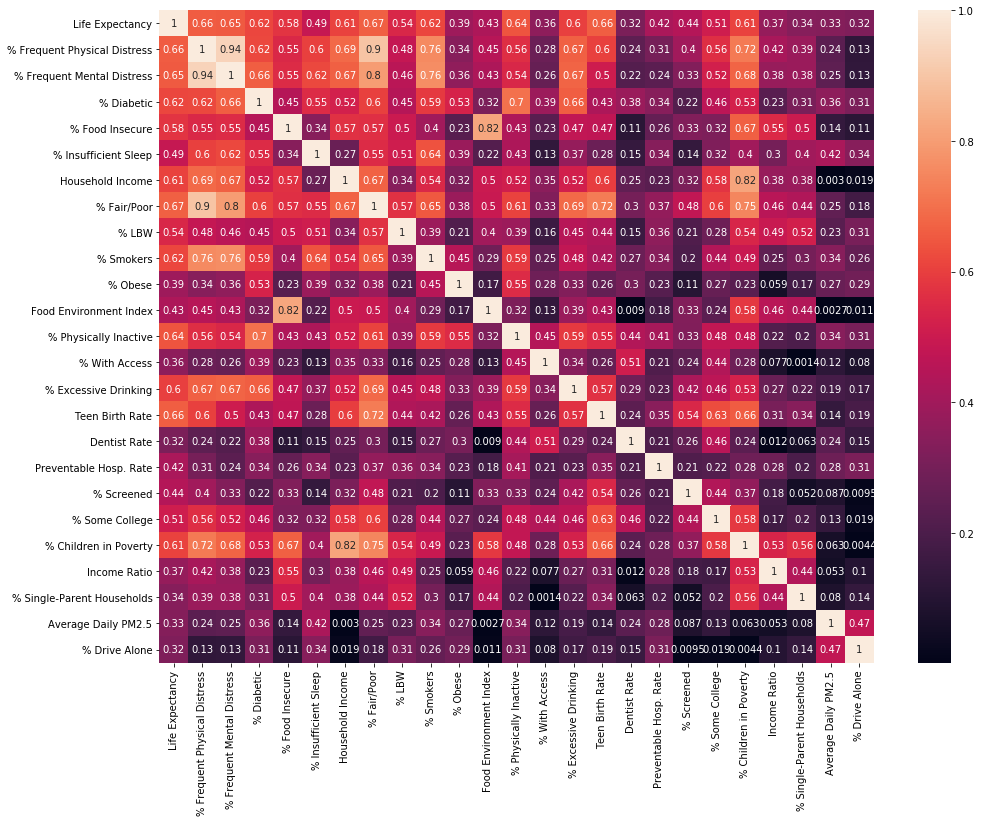

In [38]:
df_att = train_set[list(list_attr)]
fig = plt.figure(figsize=(16,12))
sns.heatmap(df_att.corr().abs(), annot=True)

Preventing multicoliinearity in our model

In [39]:
corr = df_att.corr() < 0.75
corr.reset_index(drop=False,inplace=True)
corr.rename(columns={'index': 'Attribute'},inplace=True)

In [40]:
for i in corr.columns:
    for j in list(range(1,len(corr))):
        if corr[i][j] == False:
            if i != corr.Attribute[j]:
                print(f'High chance of multicollinearity between: {i} and {corr.Attribute[j]}\n')
            else:
                pass
        else:
            pass

High chance of multicollinearity between: % Frequent Physical Distress and % Frequent Mental Distress

High chance of multicollinearity between: % Frequent Physical Distress and % Fair/Poor

High chance of multicollinearity between: % Frequent Physical Distress and % Smokers

High chance of multicollinearity between: % Frequent Mental Distress and % Frequent Physical Distress

High chance of multicollinearity between: % Frequent Mental Distress and % Fair/Poor

High chance of multicollinearity between: % Frequent Mental Distress and % Smokers

High chance of multicollinearity between: % Fair/Poor and % Frequent Physical Distress

High chance of multicollinearity between: % Fair/Poor and % Frequent Mental Distress

High chance of multicollinearity between: % Smokers and % Frequent Physical Distress

High chance of multicollinearity between: % Smokers and % Frequent Mental Distress



The variables we should exclude from our model are:
% Frequent Physical Distress 
% Frequent Mental Distress

In [41]:
multicollinear = ['% Frequent Physical Distress', '% Frequent Mental Distress']

In [42]:
predict_variables = df_att.drop(multicollinear, axis=1)
predict_variables.drop('Life Expectancy', axis=1, inplace=True)

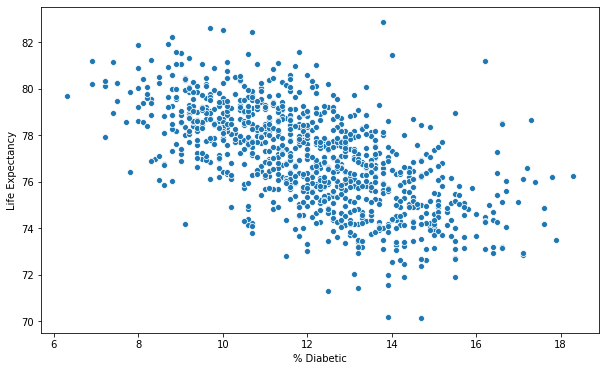

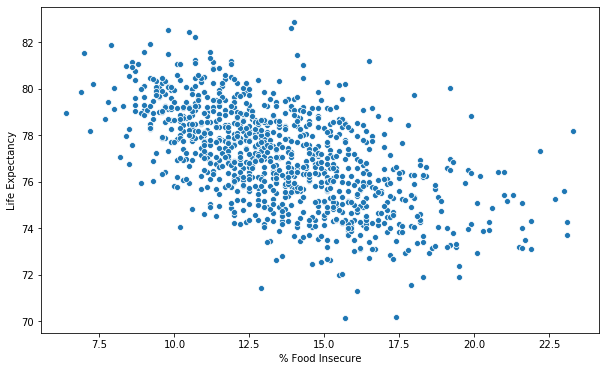

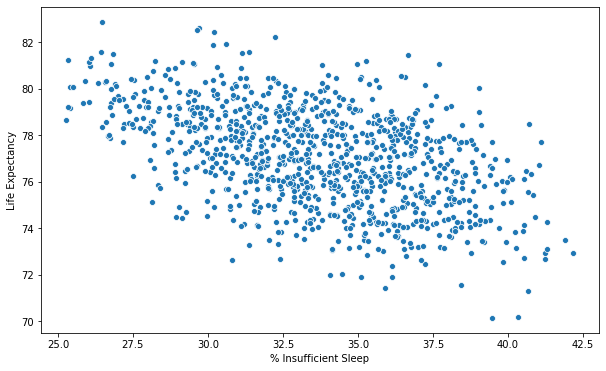

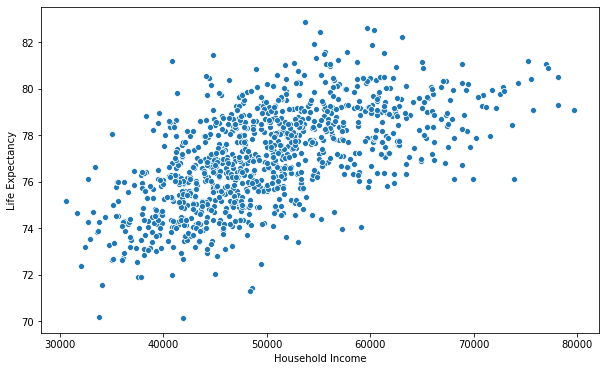

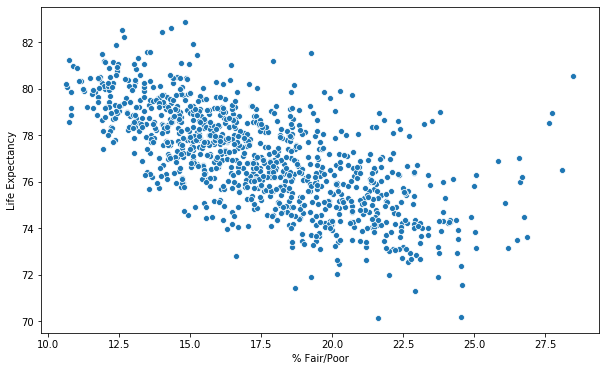

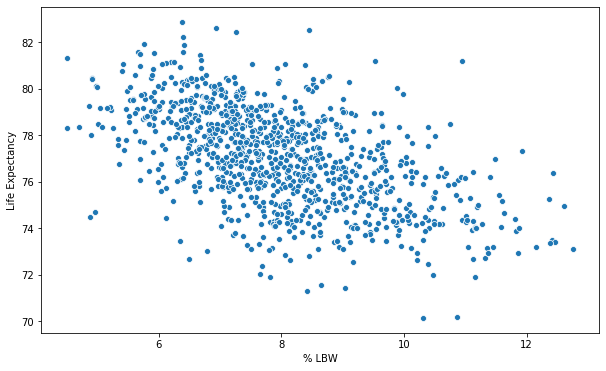

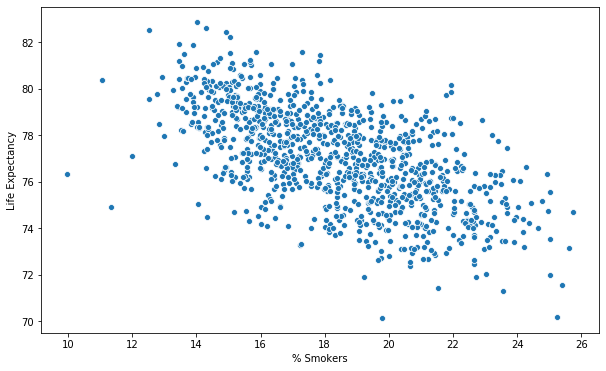

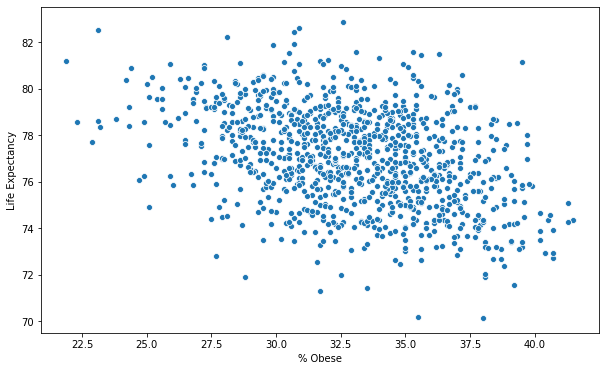

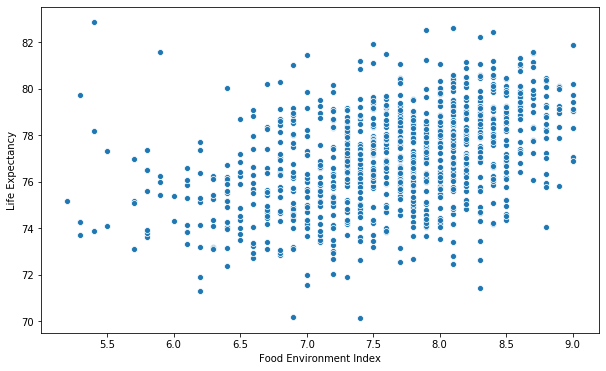

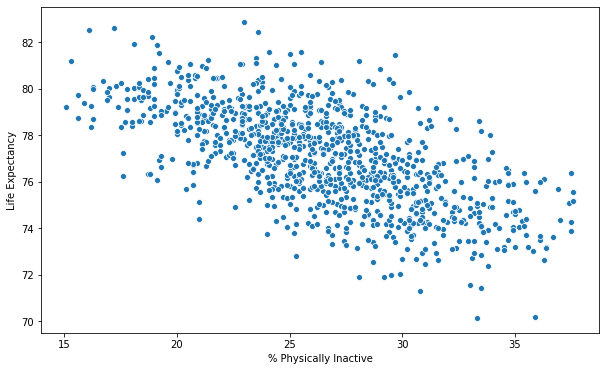

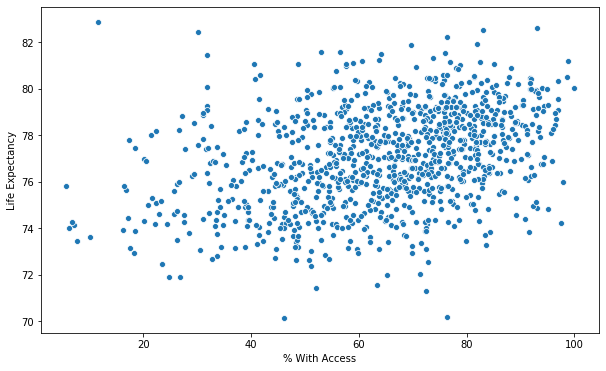

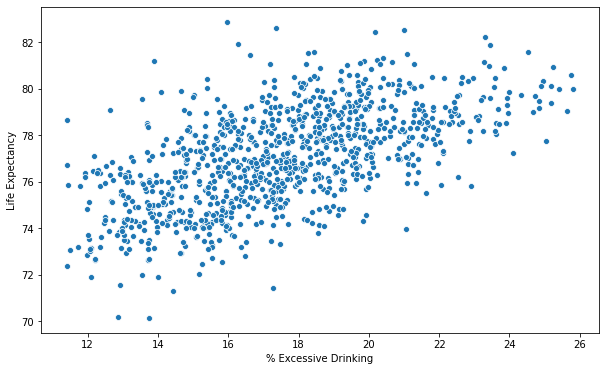

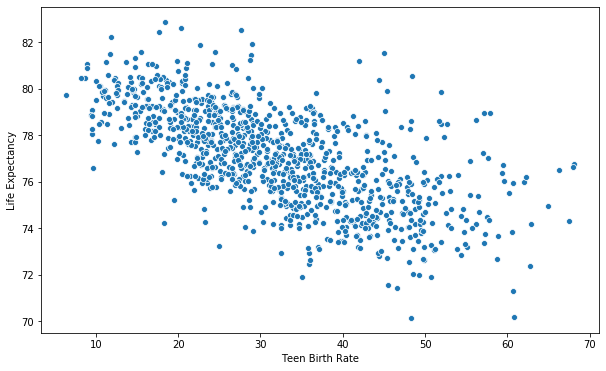

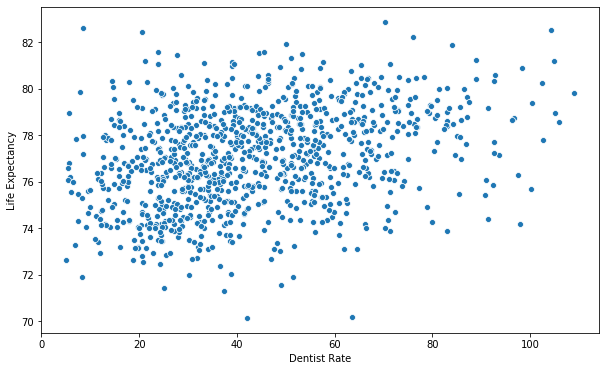

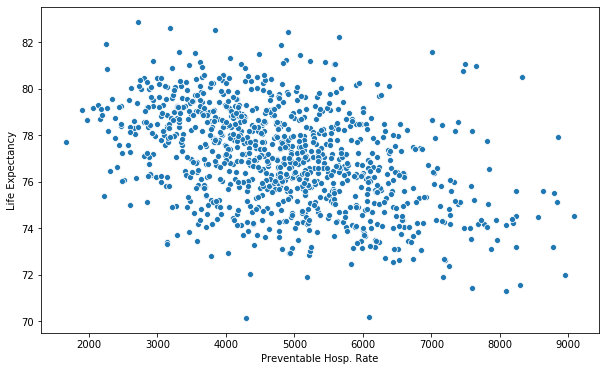

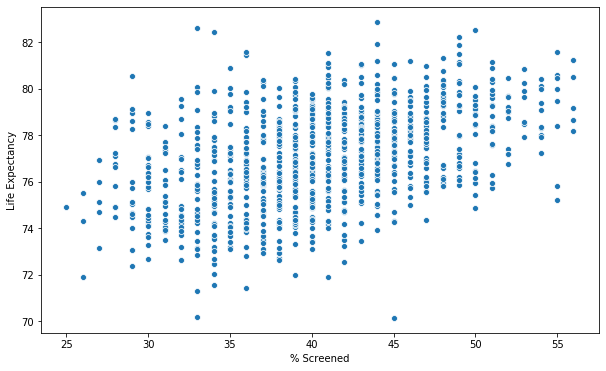

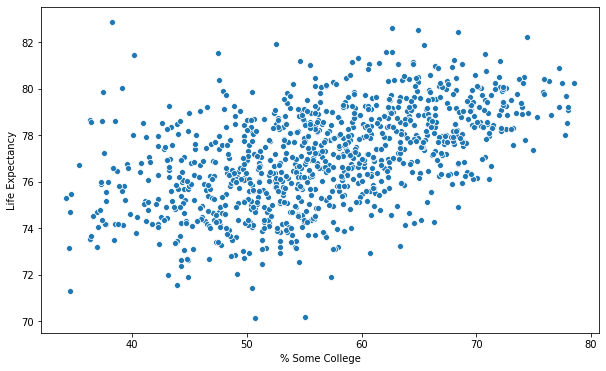

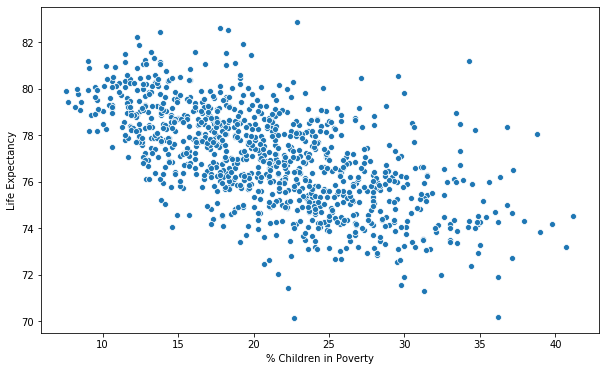

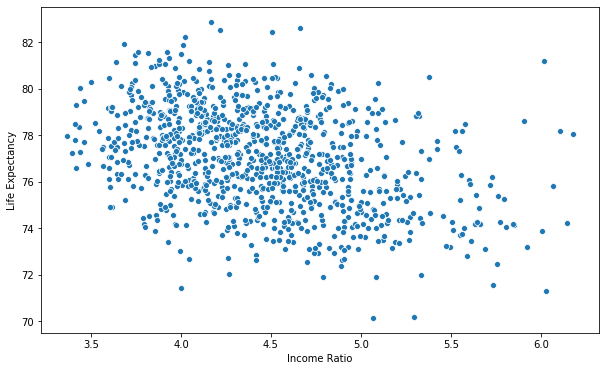

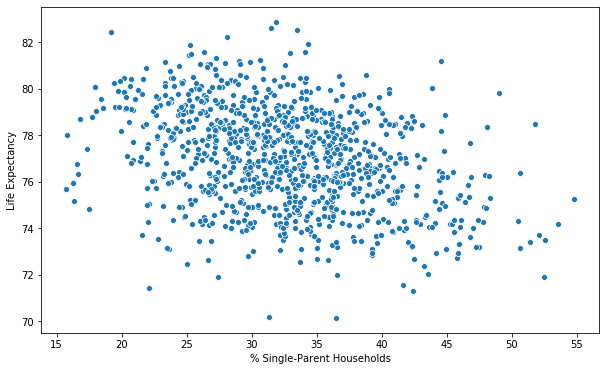

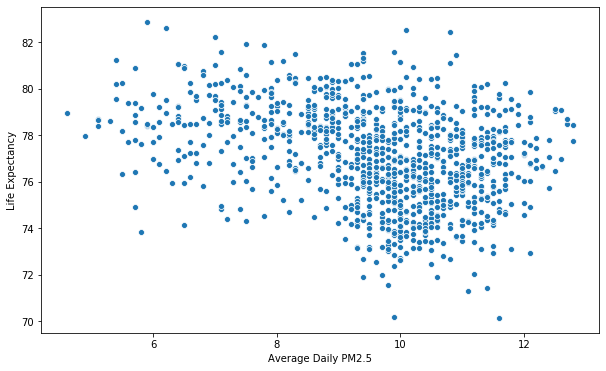

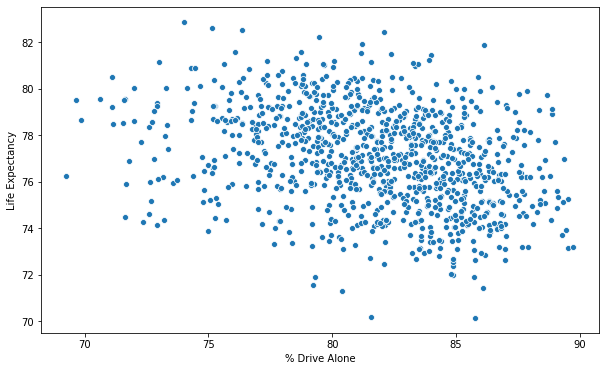

In [43]:
for i in predict_variables.columns:
    fig = plt.figure(figsize=(10,6))
    sns.scatterplot(x = predict_variables[i],y=target)
    plt.xlabel(i)
    plt.ylabel('Life Expectancy')
    plt.show()

In [44]:
predict_variables.drop(['% Screened', 'Food Environment Index', 'Average Daily PM2.5'],axis=1, inplace=True)
# 

## Running a new model

In [45]:
#Scaling the training set
scaler = StandardScaler()
scaled = scaler.fit_transform(predict_variables)

In [46]:
df1_scaled = pd.DataFrame(scaled , columns=predict_variables.columns)

In [47]:
lin_reg = LinearRegression()
c_val = KFold(n_splits=5, shuffle=True, random_state=42)
scores0 = cross_val_score(lin_reg, scaled, target, scoring='neg_mean_squared_error', cv=c_val)
lin_score0_r2 = np.mean(cross_val_score(lin_reg, scaled, target, scoring='r2', cv=c_val))
lin_scores0_rmse = np.sqrt(-scores0)

In [48]:
display_scores(lin_scores0_rmse,lin_score0_r2)

Scores:  [1.16571201 1.2511087  1.17803078 1.15539447 1.188542  ]
Mean:  1.187757591628139
Standard Deviation:  0.03359157129586607
r2:  0.674867497484114


In [49]:
import statsmodels.api as sm
preds = sm.add_constant(df1_scaled)
ols_model = sm.OLS(target,preds)
ols_result = ols_model.fit()

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Residual is not normal 8.306270776338089e-10


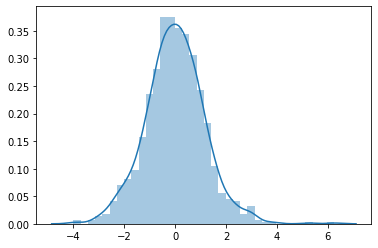

In [50]:
k2_resid, p_resid = stats.normaltest(ols_result.resid)
if p_resid < alpha:  # null hypothesis: x comes from a normal distribution
    print("Residual is not normal",p_resid)
else:
    print("Residual is normal")
sns.distplot(ols_result.resid)

Our residuals are little bit skewed but close to normal.

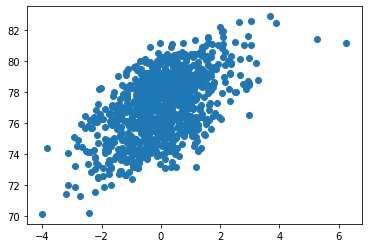

In [51]:
plt.scatter(ols_result.resid,target)

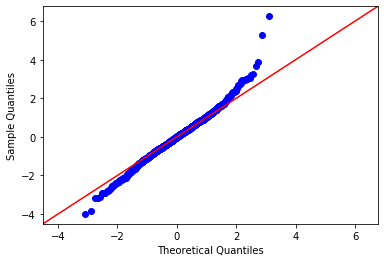

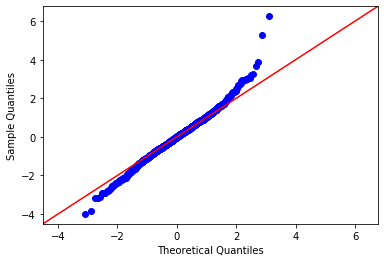

In [52]:
sm.qqplot(ols_result.resid, line='45')

In [53]:
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life Expectancy   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     117.6
Date:                Wed, 15 Jan 2020   Prob (F-statistic):          5.76e-237
Time:                        17:47:06   Log-Likelihood:                -1566.5
No. Observations:                1000   AIC:                             3173.
Df Residuals:                     980   BIC:                             3271.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         77.0368      0.037   2080.696      0.000      76.964      77.109
% Diabetic                    -0.1378      0.068     -2.038      0.042      -0.270      -0.005
% Food Insecure               -0.3450      0.056     -6.198      0.000      -0.454      -0.236
% Insufficient Sleep          -0.1729      0.060     -2.881      0.004      -0.291      -0.055
Household Income               0.3749      0.076      4.920      0.000       0.225       0.524
% Fair/Poor                    0.3094      0.082      3.771      0.000       0.148       0.470
% LBW                         -0.2822      0.055     -5.132      0.000      -0.390      -0.174
% Smokers                     -0.3746      0.061     -6.155      0.000      -0.494      -0.255
% Obese                       -0.0010      0.048     -0.021      0.983      -0.096       0.094
% Physically Inactive         -0.1339      0.065     -2.067      0.039      -0.261      -0.007
% With Access                  0.0963      0.047      2.040      0.042       0.004       0.189
% Excessive Drinking           0.1751      0.061      2.882      0.004       0.056       0.294
Teen Birth Rate               -0.6614      0.067     -9.839      0.000      -0.793      -0.529
Dentist Rate                   0.0477      0.049      0.980      0.327      -0.048       0.143
Preventable Hosp. Rate        -0.1204      0.044     -2.736      0.006      -0.207      -0.034
% Some College                 0.0115      0.059      0.195      0.846      -0.104       0.127
% Children in Poverty          0.1416      0.093      1.525      0.128      -0.041       0.324
Income Ratio                  -0.0750      0.050     -1.492      0.136      -0.174       0.024
% Single-Parent Households     0.1368      0.052      2.645      0.008       0.035       0.238
% Drive Alone                 -0.1710      0.046     -3.731      0.000      -0.261      -0.081
==============================================================================
Omnibus:                       41.818   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.526
Skew:                           0.238   Prob(JB):                     2.20e-20
Kurtosis:                       4.395   Cond. No.                         8.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Adding polynomial features

In [54]:
from sklearn.preprocessing import PolynomialFeatures

In [55]:
poly = PolynomialFeatures(2)
df1_poly = poly.fit_transform(df1_scaled)

In [56]:
scores_poly = cross_val_score(lin_reg, df1_poly, target, scoring='neg_mean_squared_error', cv=c_val)
poly_score_r2 = np.mean(cross_val_score(lin_reg, df1_poly, target, scoring='r2', cv=c_val))
poly_rmse = np.sqrt(-scores_poly)

In [57]:
display_scores(poly_rmse,poly_score_r2)

Scores:  [1.32592489 1.43607405 1.2377162  1.28156408 1.4550798 ]
Mean:  1.3472718017838752
Standard Deviation:  0.08518688937667852
r2:  0.5829452220823002


In [58]:
preds_poly = sm.add_constant(df1_poly)
poly_ols_model = sm.OLS(target,preds_poly)
poly_ols_result = poly_ols_model.fit()

Residual is not normal 2.452712662762352e-05


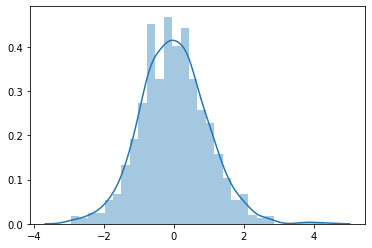

In [59]:
k2_resid, p_resid_poly = stats.normaltest(poly_ols_result.resid)
if p_resid_poly < alpha:  # null hypothesis: x comes from a normal distribution
    print("Residual is not normal",p_resid_poly)
else:
    print("Residual is normal")
sns.distplot(poly_ols_result.resid)

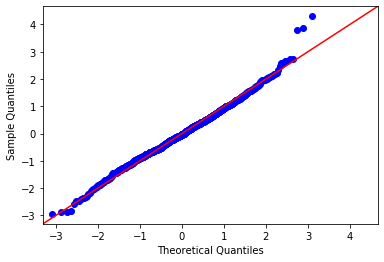

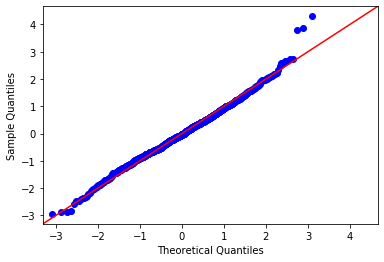

In [60]:
sm.qqplot(poly_ols_result.resid, line='45')

## Testing our model

Adding polynomial features also didn't improve our model as well.

In [61]:
y_test = test_set['Life Expectancy']
x_test = test_set[['% Diabetic', '% Food Insecure', '% Insufficient Sleep',
       'Household Income', '% Fair/Poor', '% LBW', '% Smokers', '% Obese',
       '% Physically Inactive', '% With Access', '% Excessive Drinking',
       'Teen Birth Rate', 'Dentist Rate',
       'Preventable Hosp. Rate', '% Some College',
       '% Children in Poverty', 'Income Ratio', '% Single-Parent Households',
       '% Drive Alone']]

In [62]:
scaler = StandardScaler()
scaled_final_x_train= scaler.fit_transform(predict_variables)
scaled_final_x_test = scaler.fit_transform(x_test)
lin_final = LinearRegression().fit(scaled_final_x_train,target)
scores_final = cross_val_score(lin_final, scaled_final_x_train, target, scoring='neg_mean_squared_error', cv=c_val)
lin_score_final_r2 = np.mean(cross_val_score(lin_final, scaled_final_x_train, target, scoring='r2', cv=c_val))
lin_scores_final_rmse = np.sqrt(-scores_final)
predicted_final = lin_final.predict(scaled_final_x_test)

In [63]:
display_scores(lin_scores_final_rmse, lin_score_final_r2)

Scores:  [1.16571201 1.2511087  1.17803078 1.15539447 1.188542  ]
Mean:  1.187757591628139
Standard Deviation:  0.03359157129586607
r2:  0.674867497484114


In [64]:
predicted_final

array([78.65463802, 75.75102851, 76.02812316, ..., 78.58075766,
       78.99818048, 81.02363905])

In [65]:
! pip install yellowbrick

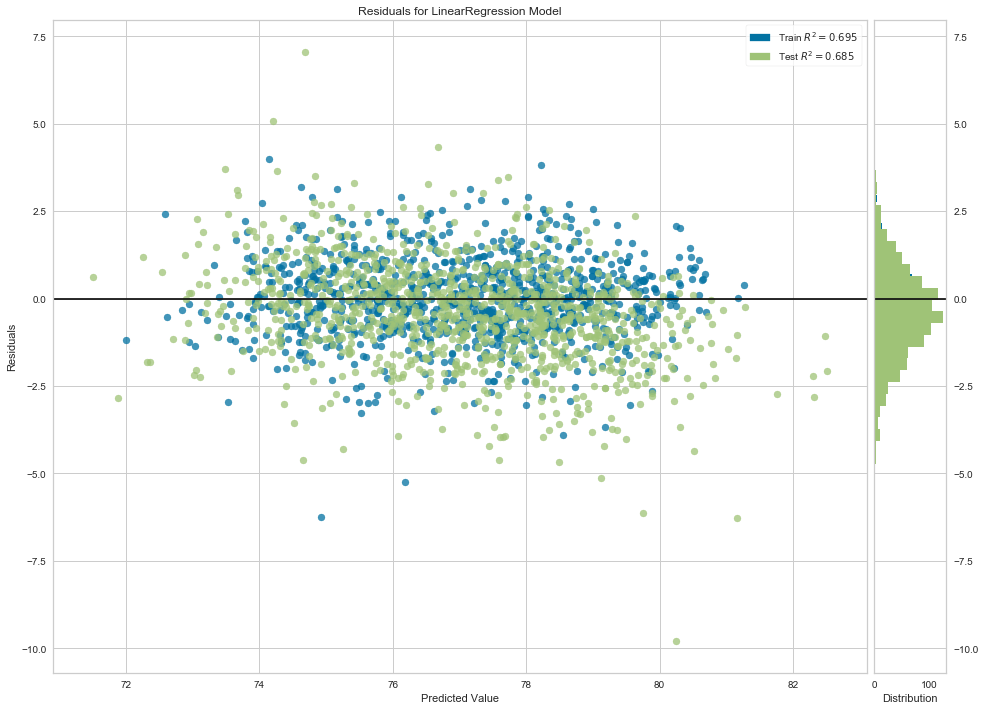

<Figure size 1152x864 with 0 Axes>

In [66]:
from yellowbrick.regressor import ResidualsPlot
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
visualizer = ResidualsPlot(lin_final, ax=ax)

fig = plt.figure(figsize=(16,12))
visualizer.fit(scaled_final_x_train, target)  # Fit the training data to the visualizer
visualizer.score(scaled_final_x_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

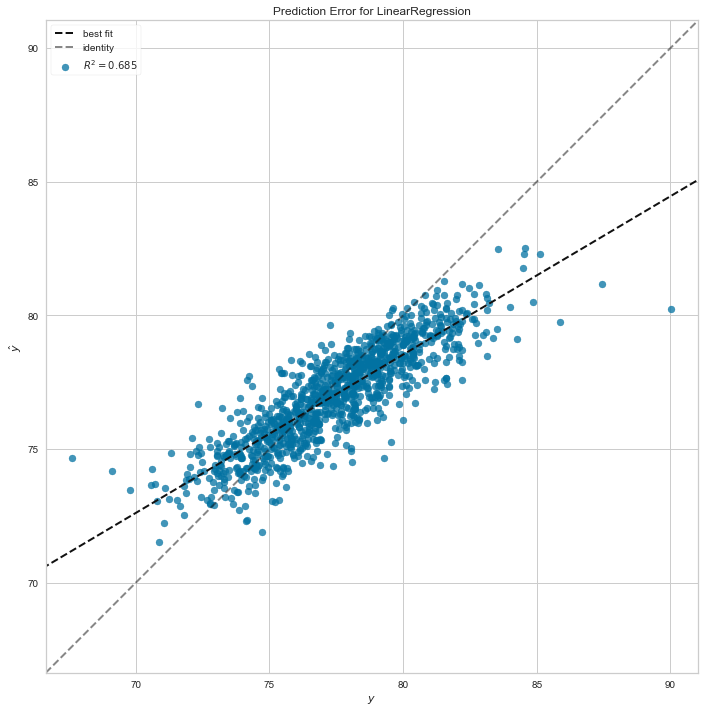

In [67]:
from yellowbrick.regressor import PredictionError
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(111)
visualizer_pred_err = PredictionError(lin_final, ax=ax1
                                     )

visualizer_pred_err.fit(scaled_final_x_train, target)  # Fit the training data to the visualizer
visualizer_pred_err.score(scaled_final_x_test, y_test)  # Evaluate the model on the test data
visualizer_pred_err.show(figsize=(16,12))